## Fine-Tuning for Classification

This notebook covers Chapter 6 of [*Build a Large Language Model from Scratch*](https://www.manning.com/books/build-a-large-language-model-from-scratch) by Sebastian Raschka (2025).

---

### Initialize the model

First, we need to reassemble the model:

In [1]:
import torch
import torch.nn as nn
import tiktoken

# tokenizer:
tokenizer = tiktoken.get_encoding("gpt2")

# LayerNorm:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # small constant to prevent division by 0 errors:
        self.eps = 1e-5

        # trainable parameters to scale and shift weights
        # if model feels that doing so will improve 
        # the training:
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mu = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # no Bessel correction (n-1)
        norm_x = (x - mu) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

# GELU:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

# feed forward:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)

# multi-head attention:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # logic check:
        assert (d_out % num_heads == 0), "Error: d_out must be divisible by num_heads!"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # final embedding size

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # linear layer for head outputs
        # (not strictly necessary, but commonly used):
        self.out_proj = nn.Linear(d_out, d_out)

        # dropout:
        self.dropout = nn.Dropout(dropout)

        # register buffer:
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape

        # queries, keys, values
        # of shape (batch_size, num_tokens, d_out):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        
        # split the matrices:
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        # transpose from (batch_size, num_tokens, num_heads, head_dim)
        # to (batch_size, num_heads, num_tokens, head_dim):
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # attention scores:
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # mask
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        # context vectors:
        context_vec = (attn_weights @ values).transpose(1, 2) # (1, 2) --> (num_tokens, num_heads)
        context_vec = context_vec.contiguous().view( # tensor of shape (batch_size, num_tokens, num_heads, head_dim)
            batch_size, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)
        return context_vec

# transformer block:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # attention:
        self.attention = MultiHeadAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            dropout=config["drop_rate"],
            qkv_bias=config["qkv_bias"]
        )

        # feed forward:
        self.ff = FeedForward(config)

        # norm:
        self.norm1 = LayerNorm(config["emb_dim"])
        self.norm2 = LayerNorm(config["emb_dim"])
        
        # dropout with shortcut:
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        shortcut = x

        # pre-layer norm:
        x = self.norm1(x)

        # attention:
        x = self.attention(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x

        # pre-layer norm:
        x = self.norm2(x)

        # feed forward network:
        x = self.ff(x)

        # dropout with shortcut:
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

# model class:
class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # token embeddings of shape (n_tokens, embedding_dims):
        self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])

        # positional embeddings of shape (context_length, embedding_dims):
        self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])

        # dropout:
        self.drop_emb = nn.Dropout(config["drop_rate"])

        # N transformer blocks (corresponds to n_layers):
        self.trf_blocks = nn.Sequential(
            *[
                TransformerBlock(config) for _
                in range(config["n_layers"])
            ]
        )

        # normalization:
        self.final_norm = LayerNorm(config["emb_dim"])

        # final output head:
        self.out_head = nn.Linear(
            config["emb_dim"], config["vocab_size"], bias=False
        )

    # forward pass:
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embeddings = self.tok_emb(in_idx)
        pos_embeddings = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = token_embeddings + pos_embeddings
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        
        logits = self.out_head(x)
        return logits

Functions for assigning pre-trained weights:

In [2]:
import numpy as np

# helper function for assigning weights:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch! Left: {left.shape} | Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


# function for loading the weights:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        # divide attention and bias weights into three equal parts for Q,K,V:
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.weight = assign(gpt.trf_blocks[b].attention.W_query.weight, q_w.T) 
        gpt.trf_blocks[b].attention.W_key.weight = assign(gpt.trf_blocks[b].attention.W_key.weight, k_w.T) 
        gpt.trf_blocks[b].attention.W_value.weight = assign(gpt.trf_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        gpt.trf_blocks[b].attention.W_query.bias = assign(gpt.trf_blocks[b].attention.W_query.bias, q_b) 
        gpt.trf_blocks[b].attention.W_key.bias = assign(gpt.trf_blocks[b].attention.W_key.bias, k_b) 
        gpt.trf_blocks[b].attention.W_value.bias = assign(gpt.trf_blocks[b].attention.W_value.bias, v_b)

        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # reuse the token embeddings weights ("weight tying"):
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

Text generation functions:

In [3]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # truncate to only the last N tokens in the context_size:
        idx_cond = idx[:, -context_size:]
        
        # predict:
        with torch.no_grad():
            logits = model(idx_cond)
        
        # focus on the last step
        # (batch, vocab_size):
        logits = logits[:, -1, :]

        # get probabilities:
        probs = torch.softmax(logits, dim=-1)

        # get next token index with the highest probability:
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)

        # append next token to previous inputs:
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # un-squeezing adds batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # squeezing removes the batch dimension
    return tokenizer.decode(flat.tolist())

### Prepare Dataset

We'll perform text classification on text messages to determine if they are spam or not-spam (i.e., "ham"). 

**Download the data:**

In [4]:
import urllib.request
import zipfile
import os
from pathlib import Path

# helper function for downloading:
def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path
):
    if data_file_path.exists():
        print(f"{data_file_path} exists; skipping download.")
        return
    
    with urllib.request.urlopen(url) as res:
        with open(zip_path, "wb") as f:
            f.write(res.read())

    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded to: {data_file_path}")

# func parameters:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip" 
zip_path = "sms_spam_collection.zip" 
extracted_path = "sms_spam_collection" 
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# download:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv exists; skipping download.


Load the `.tsv` file with Pandas:

In [5]:
import pandas as pd

# load tsv via csv func:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# inspect:
display(df)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Inspect the data frame:

In [6]:
# info:
df.info()

# label distribution:
print(f"\n{df['Label'].value_counts()}\n\n{df['Label'].value_counts(normalize=True)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Label
ham     4825
spam     747
Name: count, dtype: int64

Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


This is an ***imbalanced dataset*** where ~86.6% (N=4825) of labels are `ham` (not spam) and ~13.4% (N=747) are `spam`.

For this example, we'll sample 747 from each class (i.e., under-sampling `ham`). Then we can create a balanced dataset.
- This is not the only option with dealing with imbalanced data, but it' just used for example purposes.

In [7]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_sample = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )

    balanced_df = pd.concat([ham_sample, df.loc[df["Label"]=="spam"]])
    return balanced_df


# get balanced df:
balanced_df = create_balanced_dataset(df)

# inspect:
balanced_df.info()

# label distribution:
print(f"\n{balanced_df['Label'].value_counts()}\n\n{balanced_df['Label'].value_counts(normalize=True)}")

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 4307 to 5567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1494 non-null   object
 1   Text    1494 non-null   object
dtypes: object(2)
memory usage: 35.0+ KB

Label
ham     747
spam    747
Name: count, dtype: int64

Label
ham     0.5
spam    0.5
Name: proportion, dtype: float64


Create dummy integer values for the labels:

In [8]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

# inspect:
balanced_df.info()

# label distribution:
print(f"\n{balanced_df['Label'].value_counts()}\n\n{balanced_df['Label'].value_counts(normalize=True)}")

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, 4307 to 5567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   1494 non-null   int64 
 1   Text    1494 non-null   object
dtypes: int64(1), object(1)
memory usage: 35.0+ KB

Label
0    747
1    747
Name: count, dtype: int64

Label
0    0.5
1    0.5
Name: proportion, dtype: float64


Create a random split:
- 70% training, 10% validation, 20% testing.

In [9]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) # shuffles dataframe
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # train, val, and test sets:
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


# create sets:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)


# inspect:
print(f"Train Data:\n {train_df.sample(n=5)}\n\n")
print(f"Validation Data:\n {validation_df.sample(n=5)}\n\n")
print(f"Test Data:\n {test_df.sample(n=5)}")

# save data for reuse later:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index="None")

Train Data:
      Label                                               Text
775      0      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
952      1  Wanna have a laugh? Try CHIT-CHAT on your mobi...
977      0                 Now? I'm going out 4 dinner soon..
649      1  Talk sexy!! Make new friends or fall in love i...
890      0                          Huh so late... Fr dinner?


Validation Data:
       Label                                               Text
1102      0  I had askd u a question some hours before. Its...
1191      0           I'm in solihull, | do you want anything?
1173      1  Hi I'm sue. I am 20 years old and work as a la...
1146      0        Don know..he is watching film in computer..
1120      0                               Wot u up 2 u weirdo?


Test Data:
       Label                                               Text
1460      0  Nobody can decide where to eat and dad wants C...
1435      1  UR awarded a City Break and could WIN a £200 S...
1447      1  Y

#### Create Data Loaders

We need to create new data loaders to use our data and fine-tune our model.

We now have messages of different length: how to normalize texts? There are two primary options:
1. Truncate all messages to the length of the shortest message in the dataset or batch.
2. Pad the messages to length of the longest message in the dataset or batch.

Truncating is cheaper computationally, but results in information loss. Therefore, we'll use padding to keep the content of all messages.
- Here, we'll use `<|endoftext|>` as the padding token.

The `<|endoftext|>` token is already in the tokenizer's vocabulary at index `50256`:

In [10]:
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Let's prepare a dataset class that implements padding:

In [11]:
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        # apply padding:
        self.encoded_texts = [
            encoded_text + [pad_token_id] *
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

Load the datasets we created earlier:

In [12]:
# train dataset:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

# get the max training length:
max_length = train_dataset.max_length
print(f"Max length: {max_length}")


# get val and test datasets
# and add padding with max_length
# to match train_dataset:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=max_length,
    tokenizer=tokenizer
)

Max length: 120


Now we can create data loaders with a batch size of 8:

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

# inspect:
for input_batch, target_batch in train_loader:
    pass

print(f"Input batch dimensions: {input_batch.shape}")
print(f"Label batch dimensions: {target_batch.shape}")
print("\n")
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} testing batches")

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


130 training batches
18 validation batches
37 testing batches


### Initialize the GPT Model With Pretrained Weights

Now that the data is prepared, we can load our GPT model and attach the pre-trained weights from OpenAI.

Set up the parameters:

In [14]:
# the model we want:
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

gpt2_model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

BASE_CONFIG.update(gpt2_model_configs[CHOOSE_MODEL])

print(f"{CHOOSE_MODEL} config:\n")
for k,v in BASE_CONFIG.items():
    print(f"\t{k}: {v}")

gpt2-small (124M) config:

	vocab_size: 50257
	context_length: 1024
	drop_rate: 0.0
	qkv_bias: True
	emb_dim: 768
	n_layers: 12
	n_heads: 12


Get weights and load them into the model:

In [15]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-04-04 09:39:17.628995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743773957.677226  465225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743773957.692860  465225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743773957.771375  465225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743773957.771432  465225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743773957.771435  465225 computation_placer.cc:177] computation placer alr

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

Test the model's text generation:

In [16]:
INPUT_PROMPT = "Every effort moves"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(INPUT_PROMPT, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves forward, but it's not enough.

"I'm not going


Note that the model does not have the ability to classify text yet:

In [17]:
classification_prompt = """
Is the follow text 'spam'? Answer 'yes' or 'no':
    'You are a winner you have be specially selected to receive
    $1000 cash or a $2000 reward
"""

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(classification_prompt, tokenizer),
    max_new_tokens=25,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


Is the follow text 'spam'? Answer 'yes' or 'no':
    'You are a winner you have be specially selected to receive
    $1000 cash or a $2000 reward

'You are a winner you have be specially selected to receive $1000 cash or a $2000 reward

'You


### Adding a Classification Head

The model has to be modified to perform classification. This entails replacing the original ***output layer*** that maps the hidden representation to a vocab of size 50,257 to a smaller layer that only maps to two classes, `[0, 1]`.

- In this example, instead of using a single output node (which is possible since this is binary classification), the number of output nodes will match the number of classes.

Additionally, because the model is already pretrained we **do not** need to fine-tune all model layers.
- It's better to focus on the last layers closest to the output.

Glimpse the model's architecture:

In [18]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

We're going to replace the `out_head`: the final linear layer:

In [19]:
# first, freeze the model, making all layers non-trainable:
for param in model.parameters():
    param.requires_grad = False

# now, replace the output head:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

# now, we need to make the last layer trainable:
#    -> it actually is trainable by default!

# we'll also make a few additional layers accessible to
# fine-tuning, as this can lead to better performance.
# here, we'll allow fine-tuning on the  final transformer block
# and the final layer norm:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

Notably, the model will still "work" as it perviously did:

In [20]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print(f"Inputs: {inputs}")
print(f"Inputs shape: {inputs.shape}")

with torch.no_grad():
    outputs = model(inputs)

print(f"Outputs:\n {outputs}")
print(f"Outputs dimension: {outputs.shape}")

Inputs: tensor([[5211,  345,  423,  640]])
Inputs shape: torch.Size([1, 4])
Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimension: torch.Size([1, 4, 2])


Notice that there are 4 2D outputs: this corresponds to the 4 input tokens. We only want 2 possible class labels.

How do we do this?

- Focus only on the ***last*** output token.
    - This works because of the causal attention mask mechanism.
    - The last token in a sequence accumulates the most information, since it can access the entire preceding context.
- The last token has access to data from ***all previous tokens***!

In [21]:
print(f"Last output token: {outputs[:,-1, :]}")

Last output token: tensor([[-3.5983,  3.9902]])


### Calculating the classification loss and accuracy

How do we actually get the predicted class label? It's actually simple:

1. Convert the outputs to softmax probabilities.
2. Take the index of the highest probability value in each row vector.
3. The index corresponds to `0=ham` and `1=spam`.

For example:

In [22]:
probs = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probs)
print(f"Class label: {label}")

Class label: 1


In [23]:
# we could also technically simply just take the 
# argmax of the logits, since the largest logit value
# will also correspond to the proper index:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print(f"Class label: {label}")

Class label: 1


We can now compute accuracy:

In [24]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions / num_examples

Let's test it out:

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# test on a subset of batches:
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)

val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)

test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 53.75%
Test accuracy: 50.00%


All the accuracies hover around 50%, because the model has not been fine-tuned to the classification task.

One last step remains: defining our loss function:
- Accuracy is not differentiable. 
- Hence, we'll use cross-entropy loss as a proxy to maximize accuracy.

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    # get the logits of only the last batch:
    logits = model(input_batch)[:, -1, :]

    # and the loss:
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

And we can add a loss function for our data loaders:

In [27]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

Check the initial loss on the untrained model:

In [28]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, model, device, num_batches=5
    )

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.211
Validation loss: 2.436
Test loss: 2.552


### Implement a training function

Finally, we can implement the training loop.

In [29]:
def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    # keep track of performance:
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset the gradients
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward() # calculate gradients
            optimizer.step() # update model weights
            examples_seen += input_batch.shape[0]
            global_step += 1

            # eval:
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch: {epoch+1} (Step: {global_step + 1})")
                print(f"Train loss: {train_loss:.3f} | Validation loss: {val_loss:.3f}")
            
        # accuracy:
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )

        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}%")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


# evaluation function:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

And train the model:

In [30]:
import time
torch.manual_seed(123)

start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

end_time = time.time()
runtime_mins = (end_time - start_time) / 60
print(f"Training complete! Runtime: {runtime_mins:.2f} mins.")

Epoch: 1 (Step: 1)
Train loss: 2.153 | Validation loss: 2.859
Epoch: 1 (Step: 51)
Train loss: 0.631 | Validation loss: 0.618
Epoch: 1 (Step: 101)
Train loss: 0.498 | Validation loss: 0.561
Training accuracy: 75.00%
Validation accuracy: 77.50%
Epoch: 2 (Step: 151)
Train loss: 0.494 | Validation loss: 0.508
Epoch: 2 (Step: 201)
Train loss: 0.363 | Validation loss: 0.479
Epoch: 2 (Step: 251)
Train loss: 0.455 | Validation loss: 0.360
Training accuracy: 70.00%
Validation accuracy: 92.50%
Epoch: 3 (Step: 301)
Train loss: 0.414 | Validation loss: 0.442
Epoch: 3 (Step: 351)
Train loss: 0.485 | Validation loss: 0.344
Training accuracy: 87.50%
Validation accuracy: 90.00%
Epoch: 4 (Step: 401)
Train loss: 0.220 | Validation loss: 0.190
Epoch: 4 (Step: 451)
Train loss: 0.204 | Validation loss: 0.196
Epoch: 4 (Step: 501)
Train loss: 0.147 | Validation loss: 0.091
Training accuracy: 97.50%
Validation accuracy: 97.50%
Epoch: 5 (Step: 551)
Train loss: 0.123 | Validation loss: 0.078
Epoch: 5 (Step: 601

Check out the training and validation loss over time:

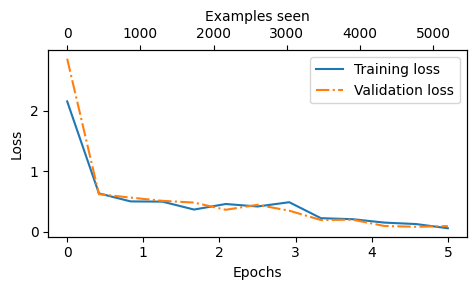

In [31]:
import matplotlib.pyplot as plt

# plotting function:
def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.show()


# plot:
epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epoch_tensor, examples_seen_tensor, train_losses, val_losses)

Check out the accuracies across epochs:

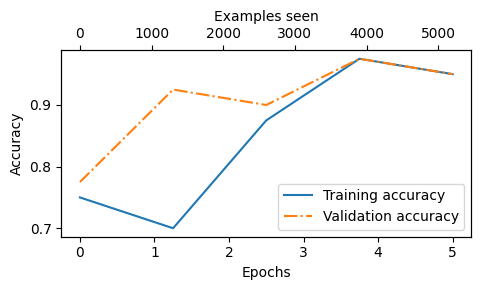

In [32]:
epoch_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epoch_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Calculate performance across the entire dataset:

In [33]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}")
print(f"validation accuracy: {val_accuracy*100:.2f}")
print(f"Testing accuracy: {test_accuracy*100:.2f}")

Training accuracy: 97.12
validation accuracy: 96.53
Testing accuracy: 95.61


### Use the model as a spam classifier

Now we can use the fine-tuned model to classify spam!

In [34]:
def classify_review(
        text, model, tokenizer, device, 
        max_length=None, pad_token_id=50256
    ):
    # eval mode:
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_length = model.pos_emb.weight.shape[0]
    input_ids = input_ids[:min(max_length, supported_length)]
    input_ids += [pad_token_id]*(max_length - len(input_ids))
    
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"

Try some examples:

In [35]:
spam_text = "You are a winner you have been specially selected to receive $1000 cash or a $2000 award."
not_spam_text = "Hey, just wanted to check if w'ere still on for dinner tonight? Let me know!"

spam_label = classify_review(
    spam_text, model, tokenizer, 
    device, max_length=train_dataset.max_length
)

ham_label = classify_review(
    not_spam_text, model, tokenizer, 
    device, max_length=train_dataset.max_length
)

print(f"Spam text prediction: `{spam_label}`")
print(f"Ham text prediction: `{ham_label}`")

Spam text prediction: `spam`
Ham text prediction: `not spam`


It worked!

Now, we can save our model in case we want to use it later:

In [36]:
torch.save(model.state_dict(), "review_classifier.pth")

And we can reload it in the future:

In [37]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(i

It worked!